# Aircraft Classification using transfer learning in fastai

I started exploring the fast.ai library for deep learning in November 2018, by means of Jeremy Howard's fantastic MOOC that goes by the same name, and have wanted to experiment with the library on some dataset to get a good feel of it. 

**fast.ai** is a Deep Learning library in Python that sits on top of Facebook's PyTorch framework for Deep Learning. In this notebook, we look at how to classify 9 aircraft models using transfer learning, on a dataset that I manually built by downloading images of 9 aircraft models from the internet, shown below:

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Import necessary libraries

In [2]:
from fastai.vision import *

## Data exploration

Our image dataset is stored as .jpg files in 9 different folders, with each folder bearing the name of the aircraft model of the images contained in the folder. We use the `ImageDataBunch.from_folder()` function to load the images and assign labels the images based on the name of the folder they're read from.

We begin by declaring the path in which the folders are located, and then loading images from that path:

In [3]:
path = Path('data/aircrafts')

np.random.seed(42)

data = ImageDataBunch.from_folder(path, 
                                  train=".", 
                                  valid_pct=0.2, # Define holdout sample size percentage
                                  ds_tfms=get_transforms(), 
                                  size=450, # image size to be fed into the model
                                  num_workers=4, 
                                  bs = 16) \
        .normalize(imagenet_stats)

The `.normalize(imagenet_stats)` method above is used to normalize the dataset based on the stats of the RGB channels from the ImageNet dataset.

Now that we've loaded our dataset, let us have a peek into what it looks like:

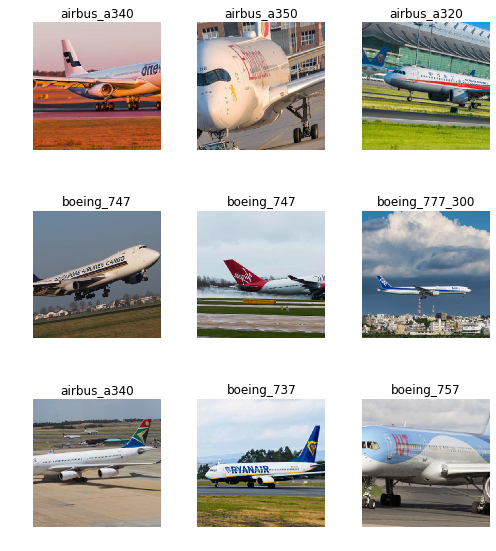

In [4]:
data.show_batch(rows=3, figsize=(7,8))

**Looks alright to me. Let's have a look at what the image classes are, the number of classes, and the sizes of the training and test sets:**

In [5]:
data.classes # What are the classes of images in our dataset?

['airbus_a320',
 'airbus_a340',
 'airbus_a350',
 'airbus_a380',
 'boeing_737',
 'boeing_747',
 'boeing_757',
 'boeing_777_300',
 'boeing_787']

In [6]:
data.c # How many classes are there in our dataste?

9

In [7]:
len(data.train_ds) # Number of training instances

2473

In [8]:
len(data.valid_ds) # Number of instances in the validation set

618

So we have 2473 images in the training set and 618 images in the test set (~ 20%) as defined in the `ImageDataBunch.from_folder()` function above.

## Training the model

We now use a pre-trained ResNet50 Convolutional Neural Net model, and use transfer learning to learn weights of only the last layer of the network. 

**Why Transfer learning?** Because with transfer learning, you begin with an existing (trained) neural network used for image recognition - and then tweak it a bit (or more) here and there to train a model for your particular use case. And why do we do that? Training a reasonable neural network would mean needing approximately 300,000 image samples, and to achieve really good performance, we're going to need at least a million images. In our case, we have approximately 2500 images in our training set - you have one guess to decide if that would have been enough if were to train a neural net from scratch. 
We use the `create_cnn()` function for loading a pre-trained ResNet50 network, that was trained on around a million images from the ImageNet database.

In [9]:
learn = cnn_learner(data, 
                    models.resnet50,
                    metrics=error_rate)

Let us now fit one cycle of 4 epochs to see how our model performs on this dataset:

In [10]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.072466,1.760313,0.611650,01:56
1,1.593187,1.308624,0.461165,01:47
2,1.289303,1.038559,0.339806,01:48
3,1.043397,0.989596,0.331715,01:48


Why just 4 epochs? I wanted to try and benchmark my first attempt with tweaks that I'd be making in a while, to make a reasonable comparison. With 4 epochs and no tweaks to our model, we've managed to achieve(?) an error rate of approximately 33% (which translates to an accuracy of 67%). How good is this? We'll get to the answer for this as we read further.

Let's have a look at what's wrong with our model predictions:

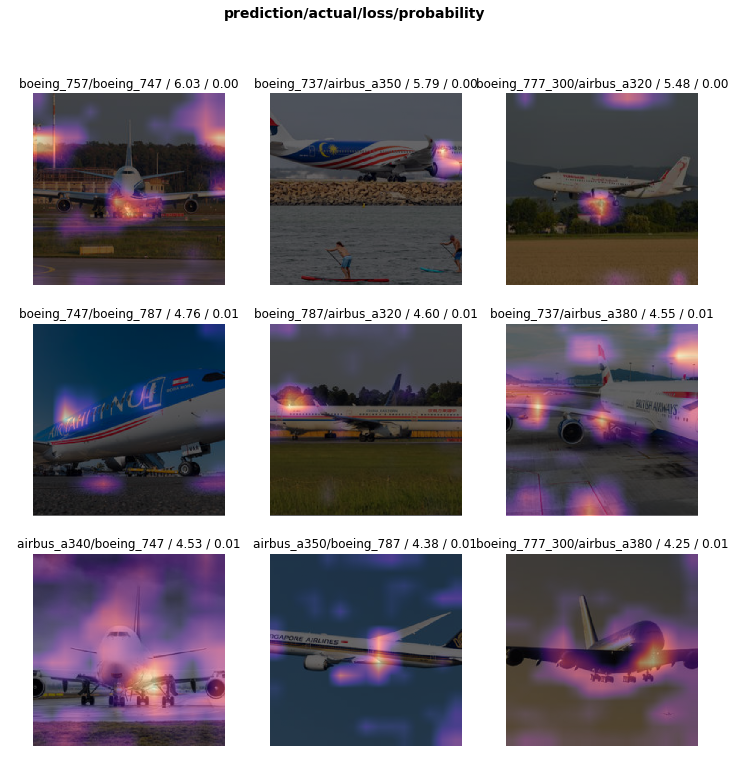

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9)

The heat-maps in the above images depict the regions in the image that *activated* the network - more simply, these are the regions in the image that helped the network in identifying the class (not very helpful in the above cases, where the losses were the highest). For more on this, [this paper](http://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf) gives a great walk-through.

One thing that stands out is the fact that most images get cropped to squares (*n x n* pixels) when it is fed into the model. This is because currently, GPU inputs can only be square images. This is a potential caveat for our use case, since one of the main components that help in identifying the aircraft is its nose, which gets cropped out in a majority of the images, and hence our model does not have enough information to learn from.

To overcome this, let us now ***squish*** our images to squares, rather than cropping them. Think of it as pressure being applied from both sides of the image that makes it look a little distorted, but retains the components of the image without cropping it. To do this, we make a slight change to our `ImageDataBunch.from_folder()` function. Initially, we had set the size argument to a value of 450, meaning that the image would be cropped to a 450 x 450 image. Let us make a change to that argument as shown below:

In [13]:
np.random.seed(42)

data_squished = ImageDataBunch.from_folder(path, 
                                  train=".", 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(), 
                                  size=(450,450), # instead of size = 450
                                  num_workers=4, 
                                  bs = 16) \
                 .normalize(imagenet_stats)

We now have changed the value of size to (450,450) instead of 450. This change, although not obvious, squishes the image to the same dimensions mentioned:

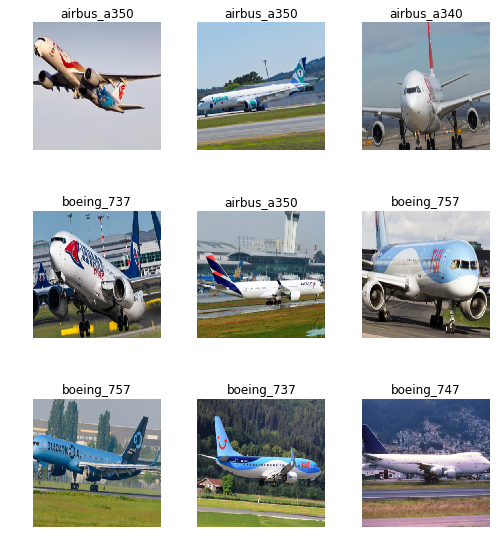

In [15]:
data_squished.show_batch(rows=3, figsize=(7,8))

The difference here is obvious, compared to the images we loaded initially where the wider ends of the image (in most cases, the nose) got cropped off:

Let us now create another learner by retraining the model with the new images:

In [16]:
learn2 = cnn_learner(data_squished, 
                     models.resnet50,       
                     metrics=error_rate)

Let us now fit our model with 4 epochs (one epoch means our model sweeps through our data once - the more the number of epochs, the more it learns in each sweep)

In [17]:
learn2.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.854450,1.373401,0.466019,01:46
1,1.328485,0.927554,0.296117,01:48
2,0.876787,0.651926,0.216828,01:47
3,0.623306,0.619018,0.190939,01:47


This results is an error rate of 19%, a decent improvement over our previous error rate of 32%. Let us now try and improve our model by fine tuning it:

Let us save the model (the weights) for now:

In [18]:
learn2.save('aircraft_classification_stg1')

One of the most important parameters to tune in a deep learning model is the learning rate. Picking the right learning rate is important, and rather than giving it a random guess or multiple trial-and-errors, we can use a beautiful function - `lr_finder()` to find a pretty good learning rate for our model to learn with. This function is an implementation of [Leslie Smith's paper on tuning neural network hyper-parameters](https://arxiv.org/abs/1803.09820), so give it a read.

Before we run `lr_find()`, we could unfreeze the whole network. I found that unfreezing the network before running `lr_find()` gets me better results. `unfreeze()` enables us to update the weights of the entire network. Ideally, we'd like to not update the weights of the earlier layers by a huge margin, but small changes (defined by low learning rates) and gradually increasing the learning rate as we move across the layers could lead to better results.

In [19]:
learn2.unfreeze()
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


`lr_find()` essentially trains the model with linearly increasing learning rates that usually range from around `10e-7` to `1`. Once that is run, we plot the graph of the loss vs. the learning rate, as shown below:

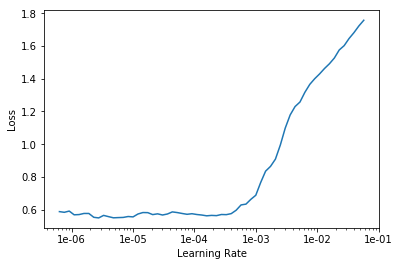

In [20]:
learn2.recorder.plot()

We can choose our learning rate such that it is lower than the rate at which the loss starts going up significantly. In the above graph, `1e-4` seems like a reasonable learning rate for the last layer group. 

We can distribute the learning rates across the layers of the network by choosing a range for the rates, where the maximum learning rate would be `1e-4` (from the above graph), and the minimum learning rate (which would be applied to the first learning group) can be a tenth of the maximum learning rate, which in this case would be `1e-5`.

To train the entire network, we first need to unfreeze the network - this is something we did right before running `lr_find()` , so we don't have to do it again.

Let us now fit one cycle to our model with 8 epochs - to read a bit more about `fit_one_cycle()` , this is a [great post on the topic.](https://sgugger.github.io/the-1cycle-policy.html)

In [21]:
learn2.fit_one_cycle(8, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.530871,0.564741,0.189320,02:22
1,0.424199,0.415925,0.124595,02:23
2,0.295266,0.320190,0.098706,02:23
3,0.212764,0.268436,0.076052,02:23
4,0.146216,0.202132,0.058252,02:23
5,0.108978,0.193563,0.061489,02:23
6,0.082238,0.178654,0.051780,02:22
7,0.058878,0.178279,0.053398,02:23


With the above steps we have reduced our error rate to ~4% - not bad! We initially started off with an error rate of 32%, and this is quite an improvement over that!

Let us now take a look at our confusion matrix to see where our model is giving erroneous predictions:

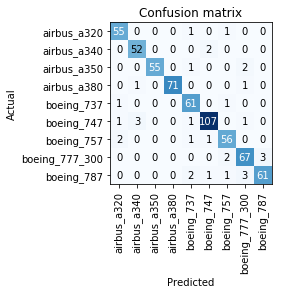

In [22]:
interp = ClassificationInterpretation.from_learner(learn2)
interp.plot_confusion_matrix()

From the confusion matrix, it looks like the model is predicting aircrafts as Boeing 787s when it was actually another model. Let us take a look at the instances where the loss was maximum:

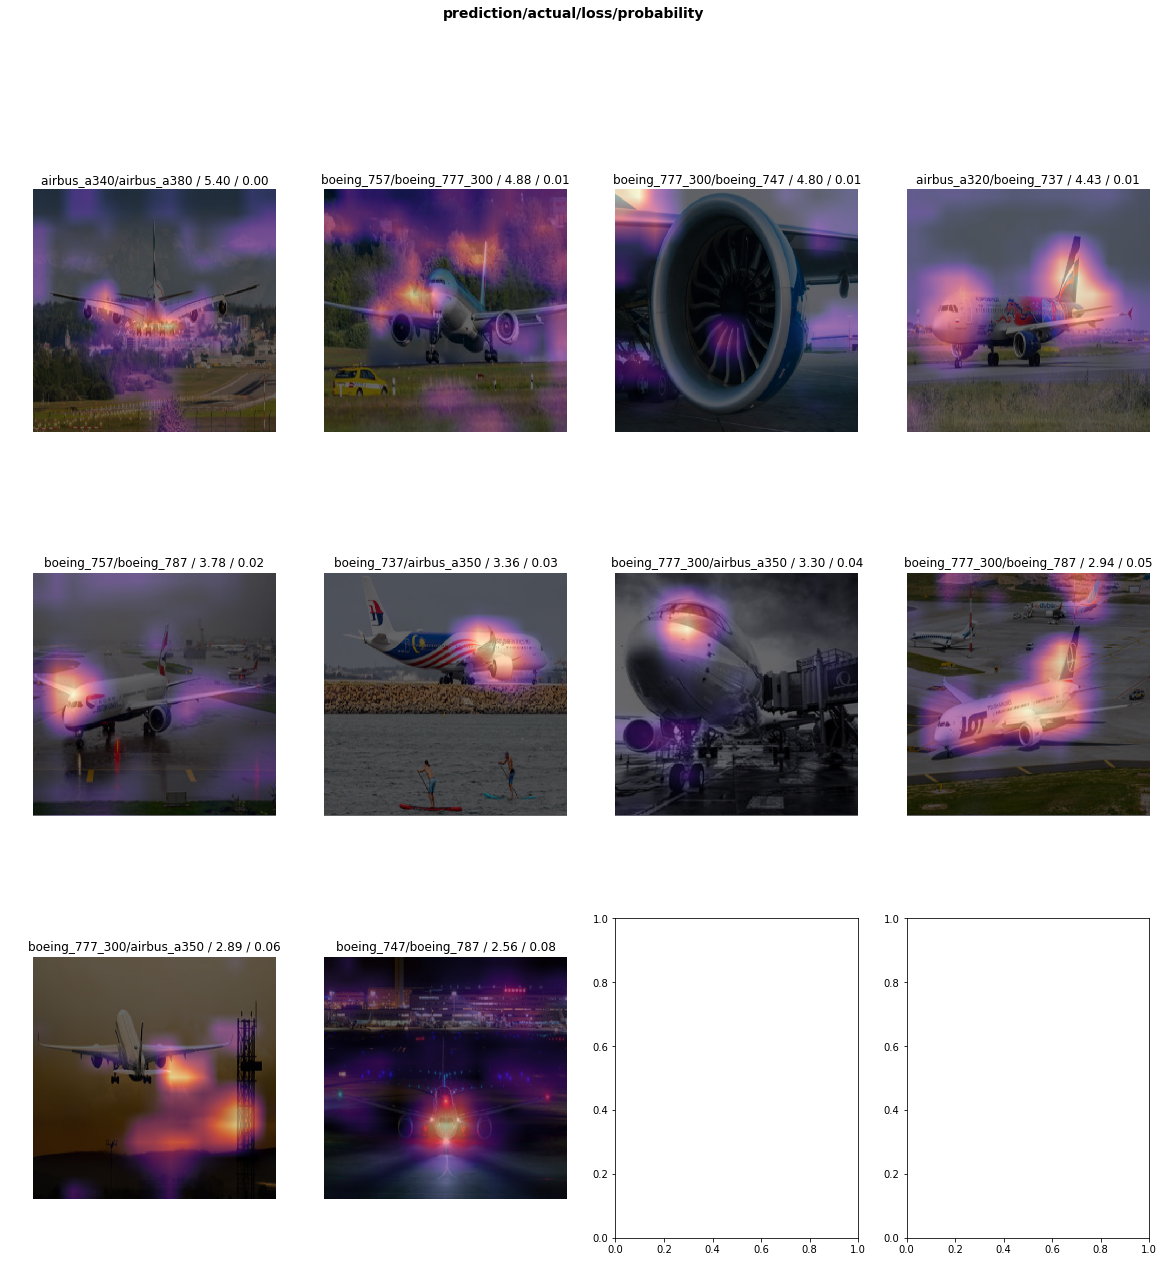

In [23]:
interp.plot_top_losses(10, figsize = (20,20))

We could give our model a pass on some of these predictions - for example, the 3rd image is just that of an engine, and I don't think I fed enough zoomed in engine images to the model to accurately distinguish aircraft engines. The 7th image is that of a zoomed in front portion of the aircraft, which, to be fair, is difficult to distinguish between aircrafts, especially with a model that we didn't tune all that much. The heat maps in the above images show the activation layers for the images.

## Conclusion

Without deeply tuning our model, we were able to get an accuracy close to 97%. There are a good number of experiments we could do further to see if the accuracy can be improved, such as increasing the number of epochs, running a single epoch cycle multiple times, more data augmentation techniques etc. The purpose of this post was to illustrate the ease of use and speed of the fastai library, and the state-of-the-art results it can achieve with very minimal tuning, and the incredible power of transfer learning to develop state-of-the-art image recognition models. The library is continuously being worked on by the folks at fast.ai, and will inspire people to learn more about AI and its phenomenal use cases in building a better world.